<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/JuhongPark/snu-fintech-ai/blob/main/Lending_Club_SSAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 1. 1차 모델을 위한 데이터 가져오기 및 전처리

In [1]:
# Branch 지정
branch = 'develop'

# 라이브러리 설치 (2분 가량 소요됨)
#!pip install shap -q
#!pip install pytorch_tabnet -q

# 필요 파일 다운로드
#!wget https://raw.githubusercontent.com/JuhongPark/snu-fintech-ai/{branch}/LC_Data_Cleaned_0829.csv

In [2]:
seed = 42  # seed 값 설정
is_test = False  # 테스트런 설정

# 입력 변수 파라미터
target = 'loan_status_encoded'
target2 = 'moral_hazard' # 2차 모델링에서 사용
drop_list = ['id', 'int_rate', 'installment', 'sub_grade', 'grade', 'tbond_int', 'year', 'term', 'term_days', 'loan_status', 'zip_code',
             'last_pymnt_d', 'issue_d', 'days_since_issue'] # 날짜 칼럼('term_days'(전처리에서 추가됨), 'last_pymnt_d', 'issue_d', 'days_since_issue'(모델코드 앞부분에서 추가됨)) 추가
feature_list = ['loan_amnt', 'emp_length', 'revol_util', 'pub_rec', 'fico_range_high', 'fico_range_low', 'percent_bc_gt_75', 'annual_inc',
                'dti', 'delinq_2yrs', 'open_acc', 'revol_bal', 'total_acc', 'inq_last_6mths']
cat_list = ['purpose', 'addr_state', 'initial_list_status', 'home_ownership']

# 대출 이후 변수
post_list = ['Funded_amnt', 'funded_amnt_inv', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'last_credit_pull_d', 'last_pymnt_amnt', 'last_pymnt_d',
 'mths_since_last_major_derog', 'next_pymnt_d', 'out_prncp', 'out_prncp_inv', 'recoveries', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
 'total_rec_prncp', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date',
 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount', 'debt_settlement_flag', 'last_fico_range_high', 'last_fico_range_low']

# 모델 파라미터 설정
# For model
learning_rate = 0.01

# For training
#n_epochs = 10000

# For CV
cv = 10

# For SSAE
n_epochs_ssae = 10000
latent_size = 8

# 테스트 런일 경우, 에포크 수를 줄임
if is_test:
    n_epochs = 10

In [3]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap
from sklearn.ensemble import RandomForestClassifier
#from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import warnings
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
import warnings

/Users/jisu/miniconda/envs/torch/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [4]:
# Random Seed 설정
def set_random_seed(seed):
    random.seed(seed) # 파이썬 표준 라이브러리
    np.random.seed(seed) # numpy의 random 모듈에서 사용하는 seed
    torch.manual_seed(seed) # pytorch에서 사용하는 seed
    if torch.cuda.is_available(): # GPU에서 실행되는 PyTorch 연산의 무작위성을 제어
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# seed 값 설정
set_random_seed(seed)

## 1.1 데이터 다운로드하기

In [5]:
# 모든 행이 화면에 표시되도록 설정합니다.
pd.set_option('display.max_rows', None)

# 파일 로드
file_path = 'LC_Data_Cleaned_0902.csv'
df = pd.read_csv(file_path)

# 테스트 런일 경우, 데이터 크기 줄이기
if is_test:
    df = df.sample(frac=0.01, random_state=seed)

In [6]:
# 날짜 열을 datetime 객체로 변환
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%Y', errors='coerce')
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%Y-%m-%d', errors='coerce')

# 두 날짜 간의 차이를 계산하여 새로운 열에 저장
df['days_since_issue'] = (df['last_pymnt_d'] - df['issue_d']).dt.days

## 1.2 데이터 전처리

1차 모델을 위한 데이터 준비

In [7]:
df_raw = df.copy()

df_raw['term_num']=df_raw.apply(lambda row: 36 if row['term'] == 0 else 60,axis =1)

In [8]:
# 기존 df 에 있는 칼럼 중에서, drop_list 및 post_list의 칼럼 제거
drop_list = list(set(df.columns) & set(drop_list + post_list))

# 불필요한 변수 Drop
df = df.drop(columns = drop_list)

# 결측치 처리
df = df.fillna(0)
df.shape

(222028, 59)

In [9]:
X = df.drop(columns=[target])
y = df[target]

In [10]:
df.columns

Index(['loan_amnt', 'funded_amnt', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_90g_dpd_24m', 'num_tl_op_pa

# 2. 1차 모델 선택

## 2.1 테스트 세트 만들기

In [11]:
# Torch 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if not is_test else "cpu" 

In [12]:
# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
X_obj = X_test.join(df_raw[['total_pymnt','recoveries','collection_recovery_fee','tbond_int','term_num']])

In [14]:
# 언더샘플링 객체 생성
print(f"Original y_train distribution: {y_train.value_counts()}")
print(len(X_train), len(X_test), len(y_train), len(y_test))

Original y_train distribution: loan_status_encoded
0    147586
1     30036
Name: count, dtype: int64
177622 44406 177622 44406


In [15]:
rus = RandomUnderSampler()

# train 데이터셋에 대해 언더샘플링 수행
X_train, y_train = rus.fit_resample(X_train, y_train)

# 결과 확인
print(f"Resampled y_train distribution: {y_train.value_counts()}")
print(len(X_train), len(X_test), len(y_train), len(y_test))

Resampled y_train distribution: loan_status_encoded
0    30036
1    30036
Name: count, dtype: int64
60072 44406 60072 44406


In [16]:
y_test.value_counts()

loan_status_encoded
0    36897
1     7509
Name: count, dtype: int64

In [17]:
# 수치형 변수 선정
num_list = list(set(X_train.columns) ^ set(cat_list))

In [18]:
# 범주형변수 - OneHotEncoder 생성 및 학습 데이터에 적합
oneHotEncoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
oneHotEncoder.fit(X_train[cat_list])

# 학습 데이터에 인코딩 적용
X_train_encoded = pd.DataFrame(
    oneHotEncoder.transform(X_train[cat_list]), 
    columns=oneHotEncoder.get_feature_names_out(cat_list), 
    index=X_train.index
)

# 테스트 데이터에 인코딩 적용
X_test_encoded = pd.DataFrame(
    oneHotEncoder.transform(X_test[cat_list]), 
    columns=oneHotEncoder.get_feature_names_out(cat_list), 
    index=X_test.index
)

# 원래 데이터프레임과 병합
X_train = X_train.drop(cat_list, axis=1).join(X_train_encoded)
X_test = X_test.drop(cat_list, axis=1).join(X_test_encoded)

In [19]:
# 표준화 (훈련 데이터에 fit_transform, 테스트 데이터에 transform)
scaler = StandardScaler()

# 수치형 변수 찾기
X_train[num_list] = scaler.fit_transform(X_train[num_list])  # (TODO): 더미 변수 표준화에서 제외해야함
X_test[num_list] = scaler.transform(X_test[num_list])

In [20]:
print(X_train.shape)
print(y_train.shape)

(60072, 119)
(60072,)


## 2.2 SSAE 모델 정의

In [21]:
# SSAE 모델 정의
class DenoisingSSAE(nn.Module):
    def __init__(self, input_dim):
        super(DenoisingSSAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),  # input_dim이 실제 데이터의 feature 수와 일치해야 함
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_size),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)  # output_dim도 input_dim과 일치해야 함
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Noise 추가 함수
def add_noise(data, noise_factor=0.2):
    noise = noise_factor * np.random.randn(*data.shape)
    noisy_data = data + noise
    noisy_data = np.clip(noisy_data, 0., 1.)
    return noisy_data

In [22]:
# Encoding 목표 설정
encoding_target = list(set(X_train.columns) ^ set(feature_list))

# 노이즈가 추가
X_train_noisy_np = add_noise(X_train[encoding_target]).to_numpy()
X_train_np = X_train[encoding_target].to_numpy()
          
input_dim = X_train_np.shape[1]  # X_train의 feature 수
print(input_dim)

105


In [23]:
# SSAE 모델 생성 및 학습 설정
ssae_model = DenoisingSSAE(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ssae_model.parameters(), lr=learning_rate)

# 모델 학습
for epoch in range(n_epochs_ssae):
    ssae_model.train()
    inputs = torch.FloatTensor(X_train_noisy_np).to(device)  # NumPy 배열 -> PyTorch 텐서
    targets = torch.FloatTensor(X_train_np).to(device)  # NumPy 배열 -> PyTorch 텐서

    # Forward pass
    outputs = ssae_model(inputs)
    loss = criterion(outputs, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{n_epochs_ssae}], Loss: {loss.item():.4f}')

Epoch [1/10000], Loss: 0.4349
Epoch [10/10000], Loss: 0.3814
Epoch [20/10000], Loss: 0.3458
Epoch [30/10000], Loss: 0.3210
Epoch [40/10000], Loss: 0.3069
Epoch [50/10000], Loss: 0.2985
Epoch [60/10000], Loss: 0.2901
Epoch [70/10000], Loss: 0.2798
Epoch [80/10000], Loss: 0.2703
Epoch [90/10000], Loss: 0.2646
Epoch [100/10000], Loss: 0.2609
Epoch [110/10000], Loss: 0.2630
Epoch [120/10000], Loss: 0.2570
Epoch [130/10000], Loss: 0.2555
Epoch [140/10000], Loss: 0.2536
Epoch [150/10000], Loss: 0.2538
Epoch [160/10000], Loss: 0.2519
Epoch [170/10000], Loss: 0.2496
Epoch [180/10000], Loss: 0.2498
Epoch [190/10000], Loss: 0.2473
Epoch [200/10000], Loss: 0.2461
Epoch [210/10000], Loss: 0.2457
Epoch [220/10000], Loss: 0.2435
Epoch [230/10000], Loss: 0.2422
Epoch [240/10000], Loss: 0.2408
Epoch [250/10000], Loss: 0.2395
Epoch [260/10000], Loss: 0.2380
Epoch [270/10000], Loss: 0.2376
Epoch [280/10000], Loss: 0.2361
Epoch [290/10000], Loss: 0.2358
Epoch [300/10000], Loss: 0.2356
Epoch [310/10000], 

## 2.3 모델 평가함수 정의

In [24]:
# 교차 검증(CV)을 위한 함수 정의
def cross_validate_model(model, X, y, cv=cv):
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"Cross-validation scores: {scores}")

## 2.4 목적함수 정의

In [25]:
# 클래스 정의
class LoanAnalysis:
    """
    1. 라벨링 수행 TN, FN, TP, FP
    2. 각 라벨별 annualized return(ar) 계산 수행: annualized return = revenue^(1/term)-1
    3. 포트폴리오 전체 ar 계산 수행(money-weighted sum)
    """
    def __init__(self, dataframe):
        self.df = dataframe.copy()
        self.label_results()

    def label_results(self):
        self.df['result'] = self.df.apply(lambda row: 
            'True Negative' if row['predicted'] == 0 and row['actual'] == 0 else 
            'False Negative' if row['predicted'] == 0 and row['actual'] == 1 else 
            'True Positive' if row['predicted'] == 1 and row['actual'] == 1 else 
            'False Positive' if row['predicted'] == 1 and row['actual'] == 0 else 
            'Other', axis=1)

    def calculate_true_negative_ar(self):
        """
        True Negative 레코드를 필터링하고 return 열을 계산합니다.
        """
        true_negative_df = self.df[self.df['result'] == 'True Negative'].copy()
        true_negative_df['revenue'] = true_negative_df['total_pymnt'] # 대출이자수익(+원금) # total_pymnt = loan_amnt + int_rate * loan_amnt
        true_negative_df['annualized_return'] = (true_negative_df['revenue']/true_negative_df['loan_amnt'])**(1/(true_negative_df['term_num']/12)) - 1

        return true_negative_df

    def calculate_false_negative_ar(self):
        """
        False Negative 레코드를 필터링하고 return 열을 계산합니다.
        """
        false_negative_df = self.df[self.df['result'] == 'False Negative'].copy()
        false_negative_df['revenue'] = false_negative_df['total_pymnt'] + false_negative_df['recoveries'] - false_negative_df['collection_recovery_fee'] # default로 인한 손실
        false_negative_df['annualized_return'] = (false_negative_df['revenue']/false_negative_df['loan_amnt'])**(1/(false_negative_df['term_num']/12)) - 1

        return false_negative_df

    def calculate_positives_ar(self):
        """
        True Positive와 False Positive 레코드를 필터링하고 return 열을 계산합니다.
        """
        positive_df = self.df[self.df['result'].isin(['True Positive', 'False Positive'])].copy()
        positive_df['annualized_return'] = positive_df['tbond_int'] # 국채수익률 = 이미 annualized 되어 있음
        return positive_df

    def process_all(self):
        """
        모든 레코드에 대한 return 열을 계산합니다.
        """
        tn_df = self.calculate_true_negative_ar()
        fn_df = self.calculate_false_negative_ar()
        pos_df = self.calculate_positives_ar()

        # 각 데이터프레임을 결합하여 반환
        final_df = pd.concat([tn_df, fn_df, pos_df])
        return final_df
    
    def calculate_portfolio_ar(self):
        final_df = self.process_all()
        # 각 개별 loan amount의 비중을 계산하고, 가중치와 해당 annualized return을 곱한 값을 합산
        final_df['weight'] = final_df['loan_amnt'] / final_df['loan_amnt'].sum()
        final_df['weighted_ar'] = final_df['weight'] * final_df['annualized_return']
    
        portfolio_annualized_return = final_df['weighted_ar'].sum()
        return portfolio_annualized_return

# 3. 1차 모델 평가, 학습

In [26]:
encoded_list = [f'e{i}' for i in range(latent_size)]
X_train_encoded = pd.concat(
                    [X_train[feature_list],
                    pd.DataFrame(ssae_model.encoder(torch.FloatTensor(X_train[encoding_target].to_numpy()).to(device)).detach().numpy(),
                                 index=X_train.index, columns=encoded_list)],
                    axis=1)

X_test_encoded = pd.concat(
                    [X_test[feature_list],
                    pd.DataFrame(ssae_model.encoder(torch.FloatTensor(X_test[encoding_target].to_numpy()).to(device)).detach().numpy(),
                                 index=X_test.index, columns=encoded_list)],
                    axis=1)

In [27]:
# 표준화 (훈련 데이터에 fit_transform, 테스트 데이터에 transform)
scalerenc = StandardScaler()
X_train_encoded[encoded_list] = scalerenc.fit_transform(X_train_encoded[encoded_list])  # (TODO): 더미 변수 표준화에서 제외해야함
X_test_encoded[encoded_list] = scalerenc.transform(X_test_encoded[encoded_list])

In [31]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

simplefilter("ignore", category=ConvergenceWarning)

# 모든 경고 무시
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, message="No further splits with positive gain")
warnings.filterwarnings("ignore", category=UserWarning, message="Stopped training because there are no more leaves")

# 모델과 파라미터 설정에 따라 평가를 실행하고 결과(연간수익률, 평가지표, Shapley Value)를 반환합니다.
def evaluate_model(model_name, model, param_set):
    try:
        model.set_params(**param_set)
        model.fit(X_train_encoded, y_train) # X_train_encoded에 fit

        y_pred = model.predict(X_test_encoded)
        y_pred = list(y_pred)
        # 포트폴리오 연간 수익률 계산
        X_obj["predicted"]= y_pred
        X_obj['actual'] = y_test
        analysis = LoanAnalysis(X_obj)
        portfolio_annualized_return = analysis.calculate_portfolio_ar()
        
        # 평가지표 계산
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)

        # Shapley Value 계산
        # evaluate_models_shap1(model, X_train, X_test)
        explainer = shap.Explainer(model, X_train_encoded)
        shap_values = explainer.shap_values(X_test_encoded)

        return accuracy, precision, recall, f1, portfolio_annualized_return, cm, shap_values
    except Exception as e:
        print(f"Error evaluating {model_name} with params: {param_set}. Error: {str(e)}")
        return None, None, None, None, None , None, None

In [32]:
# Define parameter grids for each model
logistic_param_grid = {
    'C': np.logspace(-3, 3, 10),  # Regularization strength with 10 values
    'penalty': ['l2'],
    'solver': ['lbfgs'],  # Fast solver for logistic regression with L2 regularization
    'max_iter': [1000]  # Very high iteration count
}

# Common parameter grid for XGBoost, LightGBM, and RandomForest
common_param_grid = {
    'learning_rate': np.logspace(-4, 0, 10),  # Learning rate with 10 values
    'reg_alpha': np.logspace(-3, 1, 10),  # L1 regularization with 10 values
    'reg_lambda': np.logspace(-3, 1, 10),  # L2 regularization with 10 values
    'n_estimators': [1000]  # Very high number of trees
}

svm_param_grid = {
    'C': np.logspace(-3, 3, 10),  # Regularization strength with 10 values
    'kernel': ['rbf'],  # RBF kernel is commonly used
    'gamma': ['scale'],  # Standard option for gamma
    'max_iter': [1000]  # Very high iteration count for convergence
}

# Evaluate models with parameter grids
logistic_model = LogisticRegression(n_jobs=-1)
xgb_model = xgb.XGBClassifier(n_jobs=-1, verbosity=0)  # Disable XGBoost output
lgb_model = lgb.LGBMClassifier(n_jobs=-1, verbose=-1)  # Disable LightGBM output
rf_model = RandomForestClassifier(n_jobs=-1)
svm_model = SVC()

- Base Model: Logistic Regression


[ Best Logistic Regression model ]:
  * F1 Score: 0.5176
  * Accuracy: 0.5827
  * Precision: 0.5589
  * Recall: 0.6043
  * Annualized return: 1.8437%
  * Best Parameters: {'C': 10.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}

  * Confusion Matrix:
[[21093 15804]
 [ 2727  4782]]


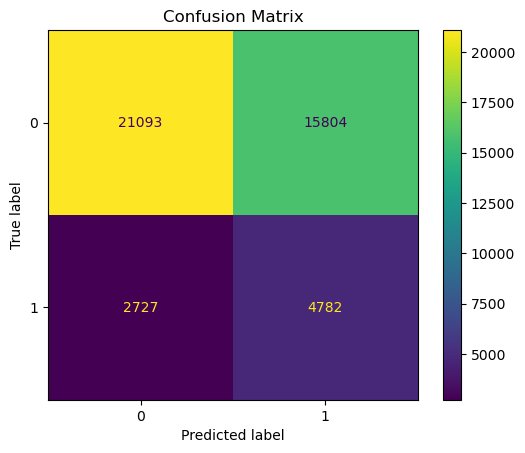

  * Shapley Value Plot:


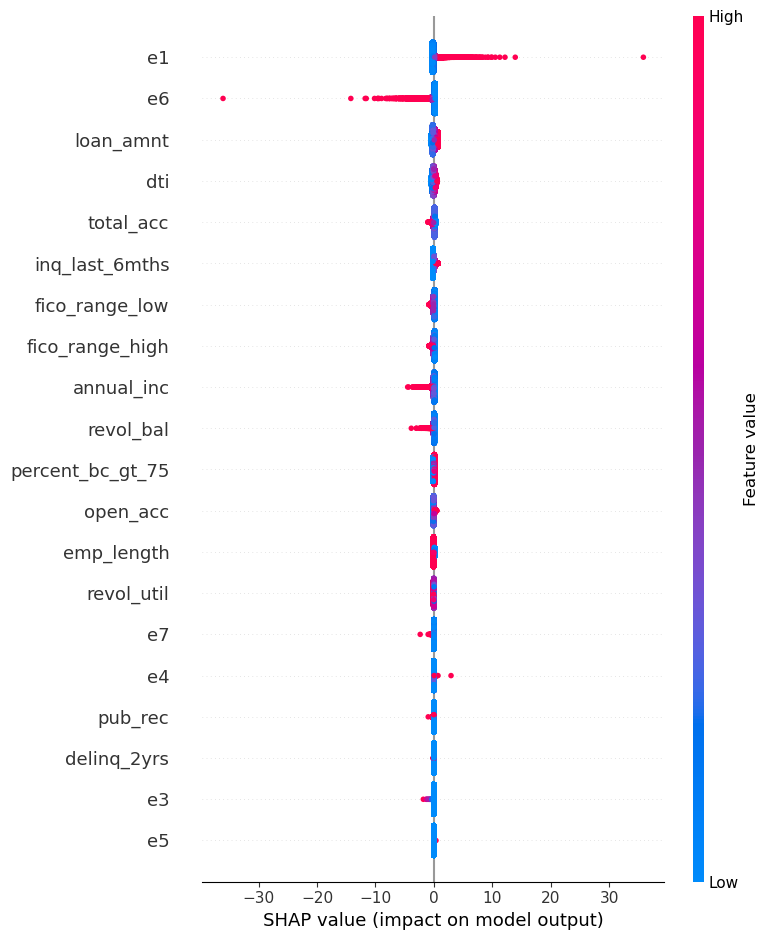

In [33]:
# Dictionary to store best results for each model
best_results = {}

# Logistic Regression with portfolio_annualized_return optimization
for params in ParameterGrid(logistic_param_grid):
    accuracy, precision, recall, f1, portfolio_annualized_return, cm, shap_values = evaluate_model('Logistic Regression', logistic_model, params)
    if accuracy is not None and ('Logistic Regression' not in best_results or portfolio_annualized_return > best_results['Logistic Regression']['portfolio_annualized_return']):
        best_results['Logistic Regression'] = {
            'model': logistic_model,
            'params': params,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'portfolio_annualized_return': portfolio_annualized_return,
            'confusion_matrix': cm,
            'shap_values': shap_values  # Shapley values 저장
        }

print(f"\n[ Best Logistic Regression model ]:")
if 'Logistic Regression' in best_results:
    print(f"  * F1 Score: {best_results['Logistic Regression']['f1_score']:.4f}")
    print(f"  * Accuracy: {best_results['Logistic Regression']['accuracy']:.4f}")
    print(f"  * Precision: {best_results['Logistic Regression']['precision']:.4f}")
    print(f"  * Recall: {best_results['Logistic Regression']['recall']:.4f}")
    print(f"  * Annualized return: {best_results['Logistic Regression']['portfolio_annualized_return']*100:.4f}%") # 목적함수 추가
    print(f"  * Best Parameters: {best_results['Logistic Regression']['params']}\n")

   # Confusion Matrix 출력
    print(f"  * Confusion Matrix:\n{best_results['Logistic Regression']['confusion_matrix']}")
    ConfusionMatrixDisplay(confusion_matrix=best_results['Logistic Regression']['confusion_matrix']).plot()
    plt.title("Confusion Matrix")
    plt.show()

    # Shapley Value 시각화
    print(f"  * Shapley Value Plot:")
    shap.summary_plot(best_results['Logistic Regression']['shap_values'], X_test_encoded)  

- Ensemble Models: RandomForest, XGBoost, LightGBM

In [ ]:
# RandomForest with portfolio_annualized_return optimization
for params in ParameterGrid(common_param_grid):
    accuracy, precision, recall, f1, portfolio_annualized_return, cm, shap_values = evaluate_model('RandomForest Classifier', rf_model, params)
    if accuracy is not None and ('RandomForest Classifier' not in best_results or portfolio_annualized_return > best_results['RandomForest Classifier']['portfolio_annualized_return']):
        best_results['RandomForest Classifier'] = {
            'model': rf_model,
            'params': params,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'portfolio_annualized_return': portfolio_annualized_return,
            'confusion_matrix': cm,
            'shap_values': shap_values  # Shapley values 저장
        }

print(f"\n[ Best RandomForest model ]:")
if 'RandomForest Classifier' in best_results:
    print(f"  F1 Score: {best_results['RandomForest Classifier']['f1_score']:.4f}")
    print(f"  Accuracy: {best_results['RandomForest Classifier']['accuracy']:.4f}")
    print(f"  Precision: {best_results['RandomForest Classifier']['precision']:.4f}")
    print(f"  Recall: {best_results['RandomForest Classifier']['recall']:.4f}")
    print(f"  Annualized return: {best_results['RandomForest Classifier']['portfolio_annualized_return']*100:.4f}%") # 목적함수 추가
    print(f"  Best Parameters: {best_results['RandomForest Classifier']['params']}\n")

    # Confusion Matrix 출력
    print(f"  * Confusion Matrix:\n{best_results['RandomForest Classifier']['confusion_matrix']}")
    ConfusionMatrixDisplay(confusion_matrix=best_results['RandomForest Classifier']['confusion_matrix']).plot()
    plt.title("Confusion Matrix")
    plt.show()

    # Shapley Value 시각화
    print(f"  * Shapley Value Plot:")
    shap.summary_plot(best_results['RandomForest Classifier']['shap_values'], X_test_encoded)


In [53]:
# LightGBM with portfolio_annualized_return optimization
for params in ParameterGrid(common_param_grid):
    accuracy, precision, recall, f1,portfolio_annualized_return, cm, shap_values = evaluate_model('LightGBM Classifier', lgb_model, params)
    if accuracy is not None and ('LightGBM Classifier' not in best_results or portfolio_annualized_return > best_results['LightGBM Classifier']['portfolio_annualized_return']):
        best_results['LightGBM Classifier'] = {
            'model': lgb_model,
            'params': params,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'portfolio_annualized_return': portfolio_annualized_return,
            'confusion_matrix': cm,
            'shap_values': shap_values  # Shapley values 저장
        }

print(f"\n[ Best LightGBM model ]:")
if 'LightGBM Classifier' in best_results:
    print(f"  F1 Score: {best_results['LightGBM Classifier']['f1_score']:.4f}")
    print(f"  Accuracy: {best_results['LightGBM Classifier']['accuracy']:.4f}")
    print(f"  Precision: {best_results['LightGBM Classifier']['precision']:.4f}")
    print(f"  Recall: {best_results['LightGBM Classifier']['recall']:.4f}")
    print(f"  Annualized return: {best_results['LightGBM Classifier']['portfolio_annualized_return']*100:.4f}%") # 목적함수 추가
    print(f"  Best Parameters: {best_results['LightGBM Classifier']['params']}\n")

    # Confusion Matrix 출력
    print(f"  * Confusion Matrix:\n{best_results['LightGBM']['confusion_matrix']}")
    ConfusionMatrixDisplay(confusion_matrix=best_results['LightGBM']['confusion_matrix']).plot()
    plt.title("Confusion Matrix")
    plt.show()

    # Shapley Value 시각화
    print(f"  * Shapley Value Plot:")
    shap.summary_plot(best_results['LightGBM']['shap_values'], X_test_encoded)

 64%|=============       | 28501/44406 [07:29<04:10]       

In [ ]:
# XGBoost with portfolio_annualized_return optimization
for params in ParameterGrid(common_param_grid):
    accuracy, precision, recall, f1, portfolio_annualized_return, cm, shap_values = evaluate_model('XGBoost Classifier', xgb_model, params)
    if accuracy is not None and ('XGBoost Classifier' not in best_results or portfolio_annualized_return > best_results['XGBoost Classifier']['portfolio_annualized_return']):
        best_results['XGBoost Classifier'] = {
            'model': xgb_model,
            'params': params,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'portfolio_annualized_return': portfolio_annualized_return,
            'confusion_matrix': cm,
            'shap_values': shap_values  # Shapley values 저장
        }

print(f"\n[ Best XGBoost model ]:")
if 'XGBoost Classifier' in best_results:
    print(f"  F1 Score: {best_results['XGBoost Classifier']['f1_score']:.4f}")
    print(f"  Accuracy: {best_results['XGBoost Classifier']['accuracy']:.4f}")
    print(f"  Precision: {best_results['XGBoost Classifier']['precision']:.4f}")
    print(f"  Recall: {best_results['XGBoost Classifier']['recall']:.4f}")
    print(f"  Annualized return: {best_results['XGBoost Classifier']['portfolio_annualized_return']*100:.4f}%") # 목적함수 추가
    print(f"  Best Parameters: {best_results['XGBoost Classifier']['params']}\n")

    # Confusion Matrix 출력
    print(f"  * Confusion Matrix:\n{best_results['XGBoost Classifier']['confusion_matrix']}")
    ConfusionMatrixDisplay(confusion_matrix=best_results['XGBoost Classifier']['confusion_matrix']).plot()
    plt.title("Confusion Matrix")
    plt.show()

    # Shapley Value 시각화
    print(f"  * Shapley Value Plot:")
    shap.summary_plot(best_results['XGBoost Classifier']['shap_values'], X_test_encoded)


In [ ]:
# XGBoost with F1 optimization
# for params in ParameterGrid(common_param_grid):
#     accuracy, precision, recall, f1, cm = evaluate_model('XGBoost Classifier', xgb_model, params)
#     if accuracy is not None and ('XGBoost Classifier' not in best_results or f1 > best_results['XGBoost Classifier']['f1_score']):
#         best_results['XGBoost Classifier'] = {
#             'model': xgb_model,
#             'params': params,
#             'accuracy': accuracy,
#             'precision': precision,
#             'recall': recall,
#             'f1_score': f1,
#             'confusion_matrix': cm
#         }

# print(f"\nBest XGBoost model:")
# if 'XGBoost Classifier' in best_results:
#     print(f"  F1 Score: {best_results['XGBoost Classifier']['f1_score']:.4f}")
#     print(f"  Accuracy: {best_results['XGBoost Classifier']['accuracy']:.4f}")
#     print(f"  Precision: {best_results['XGBoost Classifier']['precision']:.4f}")
#     print(f"  Recall: {best_results['XGBoost Classifier']['recall']:.4f}")
#     print(f"  Best Parameters: {best_results['XGBoost Classifier']['params']}\n")


# RandomForest with F1 optimization
# for params in ParameterGrid(common_param_grid):
#     accuracy, precision, recall, f1, cm = evaluate_model('RandomForest Classifier', rf_model, params)
#     if accuracy is not None and ('RandomForest Classifier' not in best_results or f1 > best_results['RandomForest Classifier']['f1_score']):
#         best_results['RandomForest Classifier'] = {
#             'model': rf_model,
#             'params': params,
#             'accuracy': accuracy,
#             'precision': precision,
#             'recall': recall,
#             'f1_score': f1,
#             'confusion_matrix': cm
#         }

# print(f"\nBest RandomForest model:")
# if 'RandomForest Classifier' in best_results:
#     print(f"  F1 Score: {best_results['RandomForest Classifier']['f1_score']:.4f}")
#     print(f"  Accuracy: {best_results['RandomForest Classifier']['accuracy']:.4f}")
#     print(f"  Precision: {best_results['RandomForest Classifier']['precision']:.4f}")
#     print(f"  Recall: {best_results['RandomForest Classifier']['recall']:.4f}")
#     print(f"  Best Parameters: {best_results['RandomForest Classifier']['params']}\n")

# # SVM with F1 optimization
# for params in ParameterGrid(svm_param_grid):
#     accuracy, precision, recall, f1, cm = evaluate_model('SVM Classifier', svm_model, params)
#     if accuracy is not None and ('SVM Classifier' not in best_results or f1 > best_results['SVM Classifier']['f1_score']):
#         best_results['SVM Classifier'] = {
#             'model': svm_model,
#             'params': params,
#             'accuracy': accuracy,
#             'precision': precision,
#             'recall': recall,
#             'f1_score': f1,
#             'confusion_matrix': cm
#         }

# print(f"\nBest SVM model:")
# if 'SVM Classifier' in best_results:
#     print(f"  F1 Score: {best_results['SVM Classifier']['f1_score']:.4f}")
#     print(f"  Accuracy: {best_results['SVM Classifier']['accuracy']:.4f}")
#     print(f"  Precision: {best_results['SVM Classifier']['precision']:.4f}")
#     print(f"  Recall: {best_results['SVM Classifier']['recall']:.4f}")
#     print(f"  Best Parameters: {best_results['SVM Classifier']['params']}\n")

# # Find the best overall model based on F1 score
# best_model_name = max(best_results, key=lambda x: best_results[x]['f1_score'])
# best_model_results = best_results[best_model_name]

# # Print the best overall model
# print(f"\nBest overall model: {best_model_name}")
# print(f"  F1 Score: {best_model_results['f1_score']:.4f}")
# print(f"  Accuracy: {best_model_results['accuracy']:.4f}")
# print(f"  Precision: {best_model_results['precision']:.4f}")
# print(f"  Recall: {best_model_results['recall']:.4f}")
# print(f"  Best Parameters: {best_model_results['params']}")

# # Plot confusion matrix for the best overall model
# disp = ConfusionMatrixDisplay(confusion_matrix=best_model_results['confusion_matrix'])
# disp.plot()
# plt.title(f"Confusion Matrix for {best_model_name}")
# plt.show()

# 4. 2차 모델을 위한 데이터 가져오기 및 전처리

In [34]:
# 모든 행이 화면에 표시되도록 설정합니다.
pd.set_option('display.max_rows', None)

# 파일 로드
file_path = 'LC_Data_Cleaned_0902.csv'
df = pd.read_csv(file_path)

# 테스트 런일 경우, 데이터 크기 줄이기
if is_test:
    df = df.sample(frac=0.01, random_state=seed)

In [35]:
# 날짜 열을 datetime 객체로 변환
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%Y', errors='coerce')
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%Y-%m-%d', errors='coerce')

# 두 날짜 간의 차이를 계산하여 새로운 열에 저장
df['days_since_issue'] = (df['last_pymnt_d'] - df['issue_d']).dt.days

In [36]:
# 부도 여부를 이미 가지고 있다고 가정 (loan_status_encoded: 0=정상, 1=부도)
# 상환기간 70% 이상 지난 후 부도 발생은 2, 아니면 0으로 설정
df['moral_hazard'] = 0  # 초기값 설정
df.loc[(df['loan_status_encoded'] == 1), 'moral_hazard'] = 1
df.loc[(df['loan_status_encoded'] == 1) & (df['days_since_issue'] / df['term_days'] >= 0.7), 'moral_hazard'] = 2

df = df[df['moral_hazard'] != 1] # default = 1 제외
df.loc[df['moral_hazard'] == 2, 'moral_hazard'] = 1 # 이진 클래스 분류 문제로 변경

2차 모델을 위한 데이터 준비

In [37]:
# 기존 df 에 있는 칼럼 중에서, drop_list 및 post_list의 칼럼 제거
drop_list = list(set(df.columns) & set(drop_list + post_list + [target]))
# drop_list = list(set(df.columns) & set(drop_list + post_list))

# 불필요한 변수 Drop
df = df.drop(columns = drop_list)

# 결측치 처리
df = df.fillna(0)
df.shape

(191462, 59)

In [38]:
X = df.drop(columns=[target2])
y = df[target2]

# 5. 2차 모델 선택

## 5.1 테스트 세트 만들기

In [39]:
# 데이터 분할: 훈련 데이터와 테스트 데이터
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [40]:
X_obj_2 = X_test_2.join(df_raw[['total_pymnt','recoveries','collection_recovery_fee','tbond_int','term_num']])

In [41]:
y_test_2.value_counts()

moral_hazard
0    55345
1     2094
Name: count, dtype: int64

In [43]:
# 언더샘플링 객체 생성
print(f"Original y_train_2 distribution: {y_train_2.value_counts()}")
print(len(X_train_2), len(X_test_2), len(y_train_2), len(y_test_2))

rus_2 = RandomUnderSampler()

# 트레인 데이터셋에 대해 언더샘플링 수행
X_train_2, y_train_2 = rus.fit_resample(X_train_2, y_train_2)

# 결과 확인
print(f"Resampled y_train_2 distribution: {y_train_2.value_counts()}")
print(len(X_train_2), len(X_test_2), len(y_train_2), len(y_test_2))

Original y_train_2 distribution: moral_hazard
0    4885
1    4885
Name: count, dtype: int64
9770 57439 9770 57439
Resampled y_train_2 distribution: moral_hazard
0    4885
1    4885
Name: count, dtype: int64
9770 57439 9770 57439


In [44]:
# 수치형 변수 선정 (범주형 변수를 제외한 수치형 변수들의 목록)
num_list_2 = list(set(X_train_2.columns) ^ set(cat_list))

In [45]:
# OneHotEncoder 생성 및 학습 데이터에 적합
oneHotEncoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
oneHotEncoder.fit(X_train_2[cat_list])

# 학습 데이터에 인코딩 적용
X_train_2_encoded = pd.DataFrame(
    oneHotEncoder.transform(X_train_2[cat_list]), 
    columns=oneHotEncoder.get_feature_names_out(cat_list), 
    index=X_train_2.index
)

# 테스트 데이터에 인코딩 적용
X_test_2_encoded = pd.DataFrame(
    oneHotEncoder.transform(X_test_2[cat_list]), 
    columns=oneHotEncoder.get_feature_names_out(cat_list), 
    index=X_test_2.index
)

# 원래 데이터프레임과 병합
X_train_2 = X_train_2.drop(cat_list, axis=1).join(X_train_2_encoded)
X_test_2 = X_test_2.drop(cat_list, axis=1).join(X_test_2_encoded)

In [46]:
# 표준화 (훈련 데이터에 fit_transform, 테스트 데이터에 transform)
scaler = StandardScaler()

# 수치형 변수 찾기
X_train_2[num_list] = scaler.fit_transform(X_train_2[num_list])  # (TODO): 더미 변수 표준화에서 제외해야함
X_test_2[num_list] = scaler.transform(X_test_2[num_list])

In [47]:
print(X_train_2.shape)
print(y_train_2.shape)

(9770, 117)
(9770,)


## 5.2 SSAE 모델 정의

In [48]:
# Encoding 목표 설정
encoding_target_2 = list(set(X_train_2.columns) ^ set(num_list))

# 노이즈가 추가
X_train_2_noisy_np = add_noise(X_train_2[encoding_target_2]).to_numpy()
X_train_2_np = X_train_2[encoding_target_2].to_numpy()
          
input_dim = X_train_2_np.shape[1]  # X_train의 feature 수
print(input_dim)

63


In [51]:
# 모델 생성 및 학습 설정
ssae_model_2 = DenoisingSSAE(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ssae_model_2.parameters(), lr=learning_rate)

# 모델 학습
for epoch in range(n_epochs_ssae):
    ssae_model_2.train()
    inputs = torch.FloatTensor(X_train_2_noisy_np).to(device)  # NumPy 배열 -> PyTorch 텐서
    targets = torch.FloatTensor(X_train_2_np).to(device)  # NumPy 배열 -> PyTorch 텐서

    # Forward pass
    outputs = ssae_model_2(inputs)
    loss = criterion(outputs, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{n_epochs_ssae}], Loss: {loss.item():.4f}')

Epoch [1/10000], Loss: 0.0701
Epoch [10/10000], Loss: 0.0407
Epoch [20/10000], Loss: 0.0398
Epoch [30/10000], Loss: 0.0387
Epoch [40/10000], Loss: 0.0331
Epoch [50/10000], Loss: 0.0270
Epoch [60/10000], Loss: 0.0253
Epoch [70/10000], Loss: 0.0238
Epoch [80/10000], Loss: 0.0221
Epoch [90/10000], Loss: 0.0206
Epoch [100/10000], Loss: 0.0199
Epoch [110/10000], Loss: 0.0196
Epoch [120/10000], Loss: 0.0193
Epoch [130/10000], Loss: 0.0191
Epoch [140/10000], Loss: 0.0189
Epoch [150/10000], Loss: 0.0186
Epoch [160/10000], Loss: 0.0184
Epoch [170/10000], Loss: 0.0181
Epoch [180/10000], Loss: 0.0179
Epoch [190/10000], Loss: 0.0178
Epoch [200/10000], Loss: 0.0176
Epoch [210/10000], Loss: 0.0173
Epoch [220/10000], Loss: 0.0172
Epoch [230/10000], Loss: 0.0170
Epoch [240/10000], Loss: 0.0171
Epoch [250/10000], Loss: 0.0168
Epoch [260/10000], Loss: 0.0167
Epoch [270/10000], Loss: 0.0166
Epoch [280/10000], Loss: 0.0165
Epoch [290/10000], Loss: 0.0167
Epoch [300/10000], Loss: 0.0164
Epoch [310/10000], 

# 6. 2차 모델 평가, 학습

In [53]:
encoded_list_2 = [f'e{i}' for i in range(latent_size)]
X_train_encoded_2 = pd.concat(
                    [X_train_2[feature_list],
                    pd.DataFrame(ssae_model_2.encoder(torch.FloatTensor(X_train_2[encoding_target_2].to_numpy()).to(device)).detach().numpy(),
                                 index=X_train_2.index, columns=encoded_list)],
                    axis=1)

X_test_encoded_2 = pd.concat(
                    [X_test_2[feature_list],
                    pd.DataFrame(ssae_model_2.encoder(torch.FloatTensor(X_test_2[encoding_target_2].to_numpy()).to(device)).detach().numpy(),
                                 index=X_test_2.index, columns=encoded_list)],
                    axis=1)

In [55]:
# 표준화 (훈련 데이터에 fit_transform, 테스트 데이터에 transform)
scalerenc = StandardScaler()
X_train_encoded_2[encoded_list_2] = scalerenc.fit_transform(X_train_encoded_2[encoded_list_2])  # (TODO): 더미 변수 표준화에서 제외해야함
X_test_encoded_2[encoded_list_2] = scalerenc.transform(X_test_encoded_2[encoded_list_2])

In [58]:
# 모델과 파라미터 설정에 따라 평가를 실행하고 결과(연간수익률, 평가지표, Shapley Value)를 반환합니다.
def evaluate_model_2(model_name, model, param_set):
    try:
        model.set_params(**param_set)
        model.fit(X_train_encoded_2, y_train_2) # X_train_encoded_2에 fit

        y_pred_2 = model.predict(X_test_encoded_2)
        y_pred_2 = list(y_pred_2)
        # 포트폴리오 연간 수익률 계산
        X_obj_2["predicted"]= y_pred_2
        X_obj_2['actual'] = y_test_2
        analysis = LoanAnalysis(X_obj_2)
        portfolio_annualized_return = analysis.calculate_portfolio_ar()
        
        # 평가지표 계산
        accuracy = accuracy_score(y_test_2, y_pred_2)
        precision = precision_score(y_test_2, y_pred_2, average='macro')
        recall = recall_score(y_test_2, y_pred_2, average='macro')
        f1 = f1_score(y_test_2, y_pred_2, average='macro')
        cm = confusion_matrix(y_test_2, y_pred_2)

        # Shapley Value 계산
        # evaluate_models_shap1(model, X_train, X_test)
        explainer = shap.Explainer(model, X_train_encoded_2)
        shap_values = explainer.shap_values(X_test_encoded_2)

        return accuracy, precision, recall, f1, portfolio_annualized_return, cm, shap_values
    except Exception as e:
        print(f"Error evaluating {model_name} with params: {param_set}. Error: {str(e)}")
        return None, None, None, None, None , None, None

- Base Model: Logistic Regression


[ Best Logistic Regression model ]:
  * F1 Score: 0.3868
  * Accuracy: 0.5305
  * Precision: 0.5114
  * Recall: 0.5813
  * Annualized return: 2.9968%
  * Best Parameters: {'C': 0.001, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}

  * Confusion Matrix:
[[29138 26207]
 [  762  1332]]


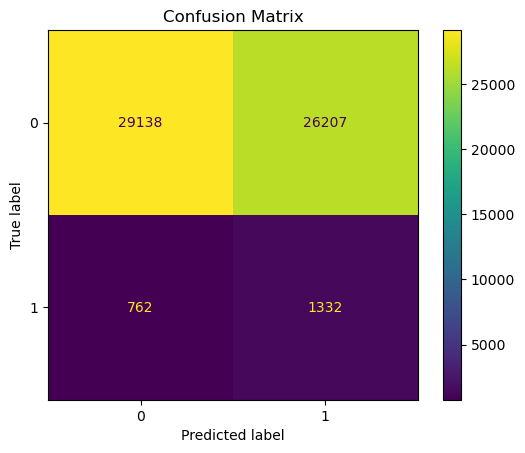

  * Shapley Value Plot:


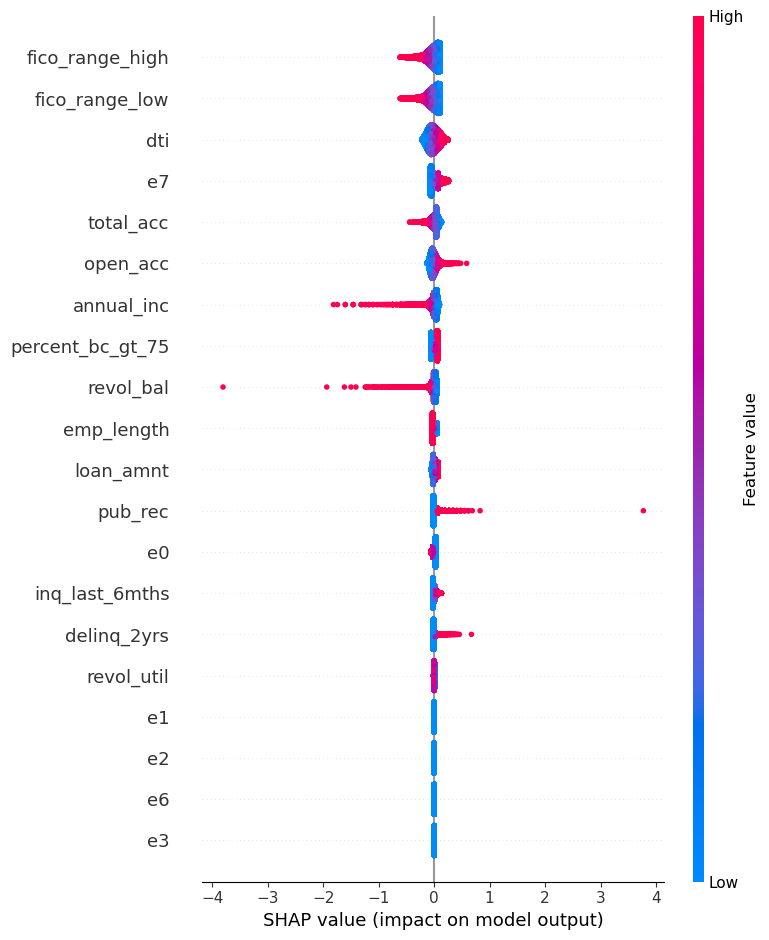

In [59]:
# Dictionary to store best results for each model
best_results = {}

# Logistic Regression with portfolio_annualized_return optimization
for params in ParameterGrid(logistic_param_grid):
    accuracy, precision, recall, f1, portfolio_annualized_return, cm, shap_values = evaluate_model_2('Logistic Regression', logistic_model, params)
    if accuracy is not None and ('Logistic Regression' not in best_results or portfolio_annualized_return > best_results['Logistic Regression']['portfolio_annualized_return']):
        best_results['Logistic Regression'] = {
            'model': logistic_model,
            'params': params,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'portfolio_annualized_return': portfolio_annualized_return,
            'confusion_matrix': cm,
            'shap_values': shap_values  # Shapley values 저장
        }

print(f"\n[ Best Logistic Regression model ]:")
if 'Logistic Regression' in best_results:
    print(f"  * F1 Score: {best_results['Logistic Regression']['f1_score']:.4f}")
    print(f"  * Accuracy: {best_results['Logistic Regression']['accuracy']:.4f}")
    print(f"  * Precision: {best_results['Logistic Regression']['precision']:.4f}")
    print(f"  * Recall: {best_results['Logistic Regression']['recall']:.4f}")
    print(f"  * Annualized return: {best_results['Logistic Regression']['portfolio_annualized_return']*100:.4f}%") # 목적함수 추가
    print(f"  * Best Parameters: {best_results['Logistic Regression']['params']}\n")

   # Confusion Matrix 출력
    print(f"  * Confusion Matrix:\n{best_results['Logistic Regression']['confusion_matrix']}")
    ConfusionMatrixDisplay(confusion_matrix=best_results['Logistic Regression']['confusion_matrix']).plot()
    plt.title("Confusion Matrix")
    plt.show()

    # Shapley Value 시각화
    print(f"  * Shapley Value Plot:")
    shap.summary_plot(best_results['Logistic Regression']['shap_values'], X_test_encoded_2)  

- Ensemble Models: RandomForest, XGBoost, LightGBM

In [ ]:
# RandomForest with portfolio_annualized_return optimization
for params in ParameterGrid(common_param_grid):
    accuracy, precision, recall, f1, portfolio_annualized_return, cm, shap_values = evaluate_model('RandomForest Classifier', rf_model, params)
    if accuracy is not None and ('RandomForest Classifier' not in best_results or portfolio_annualized_return > best_results['RandomForest Classifier']['portfolio_annualized_return']):
        best_results['RandomForest Classifier'] = {
            'model': rf_model,
            'params': params,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'portfolio_annualized_return': portfolio_annualized_return,
            'confusion_matrix': cm,
            'shap_values': shap_values  # Shapley values 저장
        }

print(f"\n[ Best RandomForest model ]:")
if 'RandomForest Classifier' in best_results:
    print(f"  F1 Score: {best_results['RandomForest Classifier']['f1_score']:.4f}")
    print(f"  Accuracy: {best_results['RandomForest Classifier']['accuracy']:.4f}")
    print(f"  Precision: {best_results['RandomForest Classifier']['precision']:.4f}")
    print(f"  Recall: {best_results['RandomForest Classifier']['recall']:.4f}")
    print(f"  Annualized return: {best_results['RandomForest Classifier']['portfolio_annualized_return']*100:.4f}%") # 목적함수 추가
    print(f"  Best Parameters: {best_results['RandomForest Classifier']['params']}\n")

    # Confusion Matrix 출력
    print(f"  * Confusion Matrix:\n{best_results['RandomForest Classifier']['confusion_matrix']}")
    ConfusionMatrixDisplay(confusion_matrix=best_results['RandomForest Classifier']['confusion_matrix']).plot()
    plt.title("Confusion Matrix")
    plt.show()

    # Shapley Value 시각화
    print(f"  * Shapley Value Plot:")
    shap.summary_plot(best_results['RandomForest Classifier']['shap_values'], X_test_encoded_2)


In [ ]:
# LightGBM with portfolio_annualized_return optimization
for params in ParameterGrid(common_param_grid):
    accuracy, precision, recall, f1,portfolio_annualized_return, cm, shap_values = evaluate_model('LightGBM Classifier', lgb_model, params)
    if accuracy is not None and ('LightGBM Classifier' not in best_results or portfolio_annualized_return > best_results['LightGBM Classifier']['portfolio_annualized_return']):
        best_results['LightGBM Classifier'] = {
            'model': lgb_model,
            'params': params,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'portfolio_annualized_return': portfolio_annualized_return,
            'confusion_matrix': cm,
            'shap_values': shap_values  # Shapley values 저장
        }

print(f"\n[ Best LightGBM model ]:")
if 'LightGBM Classifier' in best_results:
    print(f"  F1 Score: {best_results['LightGBM Classifier']['f1_score']:.4f}")
    print(f"  Accuracy: {best_results['LightGBM Classifier']['accuracy']:.4f}")
    print(f"  Precision: {best_results['LightGBM Classifier']['precision']:.4f}")
    print(f"  Recall: {best_results['LightGBM Classifier']['recall']:.4f}")
    print(f"  Annualized return: {best_results['LightGBM Classifier']['portfolio_annualized_return']*100:.4f}%") # 목적함수 추가
    print(f"  Best Parameters: {best_results['LightGBM Classifier']['params']}\n")

    # Confusion Matrix 출력
    print(f"  * Confusion Matrix:\n{best_results['LightGBM']['confusion_matrix']}")
    ConfusionMatrixDisplay(confusion_matrix=best_results['LightGBM']['confusion_matrix']).plot()
    plt.title("Confusion Matrix")
    plt.show()

    # Shapley Value 시각화
    print(f"  * Shapley Value Plot:")
    shap.summary_plot(best_results['LightGBM']['shap_values'], X_test_encoded_2)

 64%|=============       | 28501/44406 [07:29<04:10]       

In [ ]:
# XGBoost with portfolio_annualized_return optimization
for params in ParameterGrid(common_param_grid):
    accuracy, precision, recall, f1, portfolio_annualized_return, cm, shap_values = evaluate_model('XGBoost Classifier', xgb_model, params)
    if accuracy is not None and ('XGBoost Classifier' not in best_results or portfolio_annualized_return > best_results['XGBoost Classifier']['portfolio_annualized_return']):
        best_results['XGBoost Classifier'] = {
            'model': xgb_model,
            'params': params,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'portfolio_annualized_return': portfolio_annualized_return,
            'confusion_matrix': cm,
            'shap_values': shap_values  # Shapley values 저장
        }

print(f"\n[ Best XGBoost model ]:")
if 'XGBoost Classifier' in best_results:
    print(f"  F1 Score: {best_results['XGBoost Classifier']['f1_score']:.4f}")
    print(f"  Accuracy: {best_results['XGBoost Classifier']['accuracy']:.4f}")
    print(f"  Precision: {best_results['XGBoost Classifier']['precision']:.4f}")
    print(f"  Recall: {best_results['XGBoost Classifier']['recall']:.4f}")
    print(f"  Annualized return: {best_results['XGBoost Classifier']['portfolio_annualized_return']*100:.4f}%") # 목적함수 추가
    print(f"  Best Parameters: {best_results['XGBoost Classifier']['params']}\n")

    # Confusion Matrix 출력
    print(f"  * Confusion Matrix:\n{best_results['XGBoost Classifier']['confusion_matrix']}")
    ConfusionMatrixDisplay(confusion_matrix=best_results['XGBoost Classifier']['confusion_matrix']).plot()
    plt.title("Confusion Matrix")
    plt.show()

    # Shapley Value 시각화
    print(f"  * Shapley Value Plot:")
    shap.summary_plot(best_results['XGBoost Classifier']['shap_values'], X_test_encoded_2)
